In [ ]:
!git clone https://github.com/rishabh-bhardwaj-64rr/EVA5.git

Cloning into 'EVA5'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 486 (delta 108), reused 53 (delta 8), pack-reused 269
Receiving objects: 100% (486/486), 11.85 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [ ]:
cd EVA5/S11/

/content/EVA5/S11


In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

import albumentations as A
import albumentations.pytorch.transforms as APT

In [ ]:
from data_loading import transform, dataset, dataloader
from models import s11_model
from utils import plot_metrics, misclassifications, classwise_accuracy, show_image
from lr_finder import LRFinder
import normalisation as norm, loss_functions, trainer, tester, run_model
import run_grad_cam

In [ ]:
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

In [ ]:
train_transforms, test_transforms = transform.cifar10_s11_albumentations(mean, std)
trainset, testset = dataset.cifar10_dataset(train_transforms, test_transforms)
train_loader, test_loader = dataloader.cifar10_dataloader(trainset, testset, batch_size=512)
# ToTensorV2()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA available? True


In [ ]:
# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
# classes in the data
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


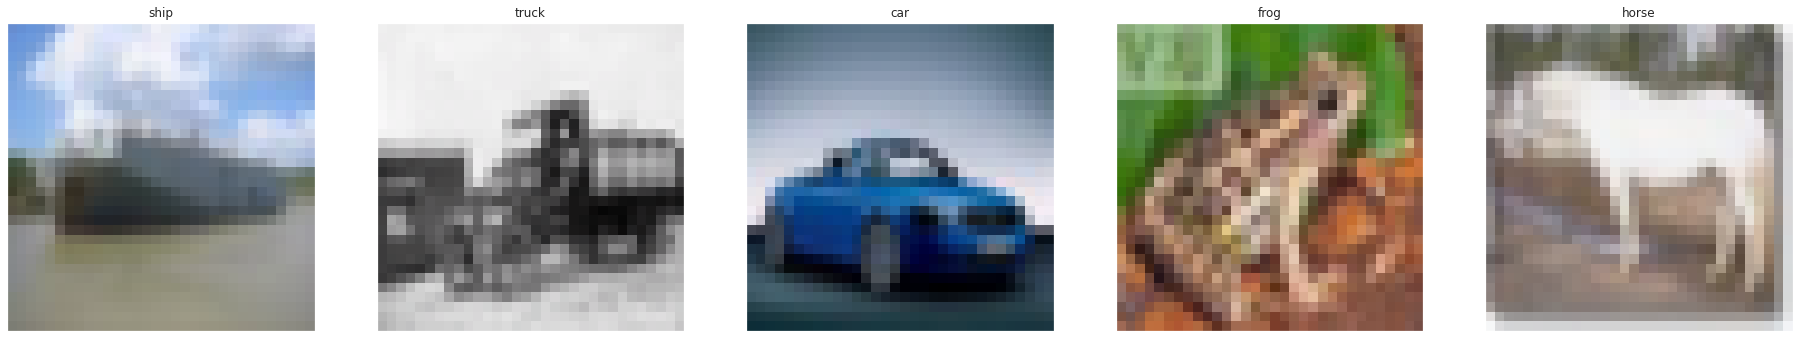

In [ ]:
# plotting dataset images(32x32 sized images)
show_image.plot_dataset_images(device, classes, test_loader, mean, std, num_of_images=5)

In [ ]:
# model summary
net = s11_model.CIFAR10S11Model().to(device)
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
         ResBlock-11          [-1, 128, 16, 16]               0
       LayerBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.71E-03


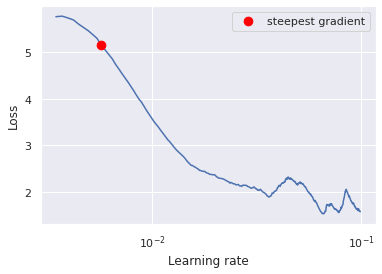

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc60e65e550>,
 0.005714285714285714)

In [ ]:

optimizer = optim.SGD(net.parameters(), lr=0.01,  momentum=0.9)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-3, end_lr=0.1, num_iter=400, step_mode='linear')

lr_finder.plot() # loss vs lr curve

# best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
# print(best_lr)

# lr_finder.reset()

In [ ]:
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print(best_lr)
lr_finder.reset()

0.06600751879699249


In [ ]:

EPOCHS = 25
max_lr_epoch = 5
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
pct_start = max_lr_epoch/EPOCHS
scheduler = OneCycleLR(optimizer=optimizer, max_lr=best_lr, epochs=EPOCHS, steps_per_epoch=len(train_loader), pct_start=pct_start,anneal_strategy='linear', div_factor=200, final_div_factor=1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

run_model.evaluation( net, train_loader, test_loader, optimizer, scheduler, EPOCHS, device,
                    train_acc, train_losses, test_acc, test_losses)

  0%|          | 0/98 [00:00<?, ?it/s]


 Epoch: 1


Loss = 1.566596269607544 Batch_id = 97 Accuracy = 31.87: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


LR from scheduler: [0.01349239579008872]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4679/10000 (46.79%)


 Epoch: 2


Loss = 1.7480268478393555 Batch_id = 97 Accuracy = 48.48: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


LR from scheduler: [0.026654753986192478]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 5000/10000 (50.00%)


 Epoch: 3


Loss = 0.919919490814209 Batch_id = 97 Accuracy = 58.74: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


LR from scheduler: [0.039817112182296235]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6265/10000 (62.65%)


 Epoch: 4


Loss = 0.9130405187606812 Batch_id = 97 Accuracy = 66.56: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.05297947037839999]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6855/10000 (68.55%)


 Epoch: 5


Loss = 1.1110769510269165 Batch_id = 97 Accuracy = 69.05: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


LR from scheduler: [0.06597400987801136]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 7125/10000 (71.25%)


 Epoch: 6


Loss = 0.7873900532722473 Batch_id = 97 Accuracy = 73.87: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


LR from scheduler: [0.06269013581786098]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7365/10000 (73.65%)


 Epoch: 7


Loss = 0.6272133588790894 Batch_id = 97 Accuracy = 78.21: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


LR from scheduler: [0.05940626175771061]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8022/10000 (80.22%)


 Epoch: 8


Loss = 0.8930823802947998 Batch_id = 97 Accuracy = 80.14: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.056122387697560235]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8147/10000 (81.47%)


 Epoch: 9


Loss = 0.6414862275123596 Batch_id = 97 Accuracy = 82.30: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


LR from scheduler: [0.05283851363740986]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7612/10000 (76.12%)


 Epoch: 10


Loss = 0.4987790286540985 Batch_id = 97 Accuracy = 83.71: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.04955463957725948]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8313/10000 (83.13%)


 Epoch: 11


Loss = 0.38666588068008423 Batch_id = 97 Accuracy = 86.18: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


LR from scheduler: [0.046270765517109104]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8287/10000 (82.87%)


 Epoch: 12


Loss = 0.33700379729270935 Batch_id = 97 Accuracy = 87.17: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.04298689145695873]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8505/10000 (85.05%)


 Epoch: 13


Loss = 0.3103055953979492 Batch_id = 97 Accuracy = 88.02: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.03970301739680836]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8535/10000 (85.35%)


 Epoch: 14


Loss = 0.3729381859302521 Batch_id = 97 Accuracy = 89.20: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.03641914333665797]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8627/10000 (86.27%)


 Epoch: 15


Loss = 0.33295178413391113 Batch_id = 97 Accuracy = 89.67: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.0331352692765076]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8739/10000 (87.39%)


 Epoch: 16


Loss = 0.3607223927974701 Batch_id = 97 Accuracy = 90.42: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


LR from scheduler: [0.029851395216357227]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8706/10000 (87.06%)


 Epoch: 17


Loss = 0.1604900062084198 Batch_id = 97 Accuracy = 90.93: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


LR from scheduler: [0.026567521156206843]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8864/10000 (88.64%)


 Epoch: 18


Loss = 0.23898810148239136 Batch_id = 97 Accuracy = 92.05: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


LR from scheduler: [0.023283647096056473]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8897/10000 (88.97%)


 Epoch: 19


Loss = 0.21877562999725342 Batch_id = 97 Accuracy = 92.90: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.019999773035906096]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8939/10000 (89.39%)


 Epoch: 20


Loss = 0.1762252002954483 Batch_id = 97 Accuracy = 93.70: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.01671589897575572]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8947/10000 (89.47%)


 Epoch: 21


Loss = 0.14123930037021637 Batch_id = 97 Accuracy = 94.08: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.013432024915605342]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8952/10000 (89.52%)


 Epoch: 22


Loss = 0.13797883689403534 Batch_id = 97 Accuracy = 94.64: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.010148150855454965]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8964/10000 (89.64%)


 Epoch: 23


Loss = 0.07958388328552246 Batch_id = 97 Accuracy = 95.67: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


LR from scheduler: [0.0068642767953045886]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9017/10000 (90.17%)


 Epoch: 24


Loss = 0.08414093405008316 Batch_id = 97 Accuracy = 96.31: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.0035804027351542117]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9050/10000 (90.50%)


 Epoch: 25


Loss = 0.0684182196855545 Batch_id = 97 Accuracy = 96.80: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


LR from scheduler: [0.00029652867500383484]



Test set: Average loss: 0.0007, Accuracy: 9076/10000 (90.76%)



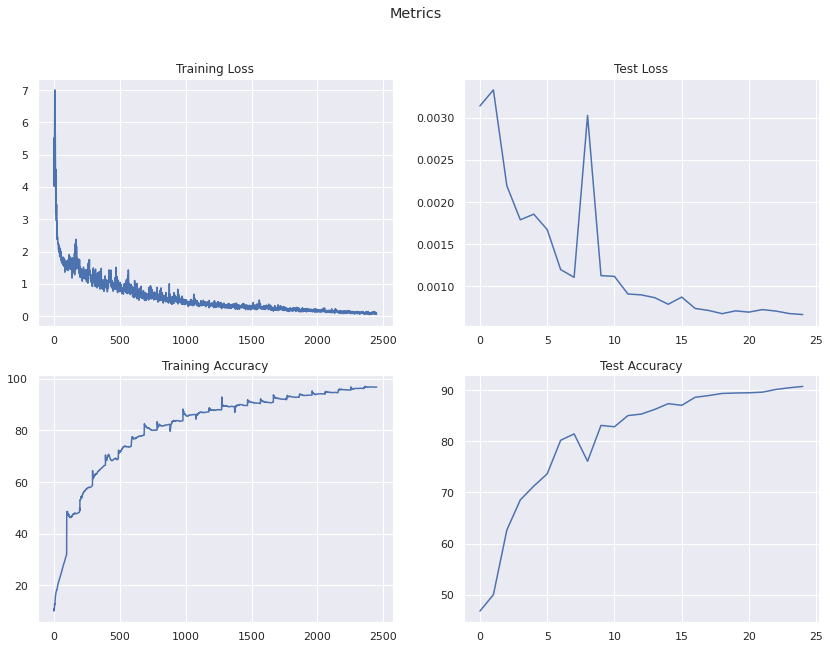

In [ ]:
train_metric = (train_acc, train_losses)
test_metric = (test_acc, test_losses)

plot_metrics.metrics(train_metric, test_metric)

In [ ]:
# classwise accuracy
classwise_accuracy.classwise_accuracy(net, test_loader, device, classes)

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 80 %
Accuracy of   cat : 75 %
Accuracy of  deer : 85 %
Accuracy of   dog : 83 %
Accuracy of  frog : 84 %
Accuracy of horse : 87 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %
